<a href="https://www.kaggle.com/code/neesham/transfer-learning-for-beginners?scriptVersionId=108922569" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## In this notebook, I am gonna show you complete end to end use of transfer leanring in action!
> For getting most out of this notebook click on the copy and edit button and strat hustling ✌️.

### Please upvote this notebook if you found it useful ❤️.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## This is the image we will try to predict.

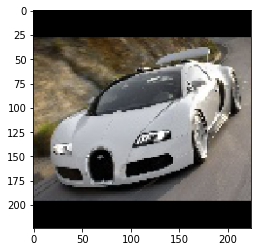

In [2]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

# This is the image we will try to predict with our models.
img_path = '../input/car-or-truck/train/Car/00023.jpeg'
img = image.load_img(img_path, target_size = (224, 224))
plt.imshow(img)


> We, humans, know that this is a picture of a car, but let's see if we can make a computer algorithm that can understand this picture.

### Reformatting the Image data.

In [3]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

## Base Model Without any Change.

https://keras.io/api/applications/ Here you can find all models that you can use for transfer learning in keras.

In [4]:
from tensorflow.keras.applications.resnet50 import ResNet50


# There are 1000 Categories that this model can classify including cars and trucks.
model = ResNet50(weights = 'imagenet')

preds = model.predict(x)

# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)

cls, description, probability = decode_predictions(preds, top=3)[0][0]

print(f'ResNet50 Predicted {description} with probability {probability}!')

2022-10-23 17:09:28.679306: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 17:09:28.815793: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 17:09:28.816570: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 17:09:28.818454: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

102981632/102967424 [==============================] - 1s 0us/step


2022-10-23 17:09:33.608135: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-23 17:09:35.211345: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


49152/35363 [=========================================] - 0s 0us/step
ResNet50 Predicted racer with probability 0.6825822591781616!


In [5]:
from tensorflow.keras.applications.vgg16 import VGG16

model1 = VGG16(weights='imagenet')

pred1 = model1.predict(x)

# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)

cls, description, probability = decode_predictions(pred1, top=3)[0][0]

print(f'ResNet50 Predicted {description} with probability {probability}!')


553476096/553467096 [==============================] - 6s 0us/step
ResNet50 Predicted racer with probability 0.6189387440681458!


## Loading the data.

#### This is a sample template that you can use to create a dataset from the directory of images. So save it for the later use.

In [6]:
# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.computer_vision.ex5 import *

# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    '../input/car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    '../input/car-or-truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


## Attaching our own head to the pretrained base.

In [7]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Input


input_tensor = Input(shape=(128, 128, 3))

# create the base pre-trained model and deattaching the head. So that we can train it on our custom classes (i.e cars and trucks).
base_model = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (128, 128, 3))

inputs = Input(shape=(128, 128, 3))

model_output = base_model(inputs, training=False)

# Convert features of shape `base_model.output_shape[1:]` to vectors
model_output = GlobalAveragePooling2D()(model_output)

# A Dense classifier with a single unit (binary classification)
outputs = Dense(1)(model_output)

model = Model(inputs, outputs)


# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer = tf.keras.optimizers.Adam(epsilon = 0.01), loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics = ['binary_accuracy'])

model.summary()

# train the model on the new data for a few epochs
# model.fit(ds_train, validation_data = ds_valid, epochs = 40)



87924736/87910968 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 2, 2, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [8]:
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=50,
)

Epoch 1/50
80/80 [==============================] - 29s 297ms/step - loss: 0.6516 - binary_accuracy: 0.6826 - val_loss: 0.5359 - val_binary_accuracy: 0.7244
Epoch 2/50
80/80 [==============================] - 5s 66ms/step - loss: 0.5040 - binary_accuracy: 0.7588 - val_loss: 0.4796 - val_binary_accuracy: 0.7559
Epoch 3/50
80/80 [==============================] - 5s 67ms/step - loss: 0.4595 - binary_accuracy: 0.7833 - val_loss: 0.4566 - val_binary_accuracy: 0.7703
Epoch 4/50
80/80 [==============================] - 5s 67ms/step - loss: 0.4325 - binary_accuracy: 0.7962 - val_loss: 0.4438 - val_binary_accuracy: 0.7781
Epoch 5/50
80/80 [==============================] - 5s 67ms/step - loss: 0.4136 - binary_accuracy: 0.8061 - val_loss: 0.4361 - val_binary_accuracy: 0.7856
Epoch 6/50
80/80 [==============================] - 5s 66ms/step - loss: 0.3993 - binary_accuracy: 0.8147 - val_loss: 0.4313 - val_binary_accuracy: 0.7884
Epoch 7/50
80/80 [==============================] - 5s 68ms/step - l

## Accuracy: 
> So the accuracy of our model on training data is almost 89% and on validation data it is 80%. It is slightly overfitted though, you can find out by examining the the graphs given below.

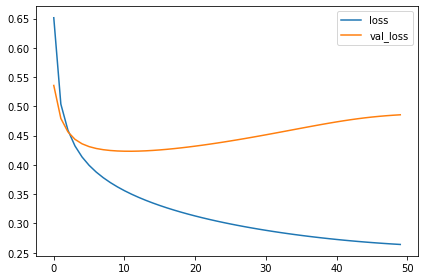

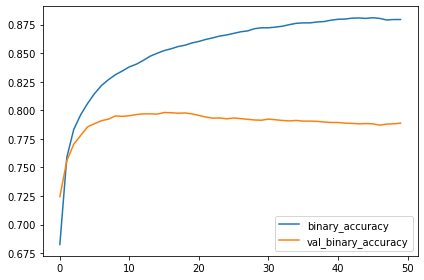

In [9]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

#### You can train it on larger epochs to increase the accuracy 🤝.

## So this is all for this notebook, thanks for reading and don't forgot to upvote it!